In [462]:
import os
import time
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import math
from sklearn.model_selection import train_test_split
from sklearn import metrics
import nltk
nltk.download('punkt')
from nltk.corpus import stopwords
import string
import re
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import GridSearchCV

import scipy as sp

[nltk_data] Downloading package punkt to /home/ec2-user/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [175]:
train_orig = pd.read_csv("data/train_F3WbcTw.csv")
test_orig = pd.read_csv("data/test_tOlRoBf.csv")

In [176]:
train_orig["text"] = train_orig['text']+train_orig['drug']
test_orig["text"] = test_orig['text']+test_orig['drug']

## Column to identify Train and test columns

In [177]:
train_orig['column'] = 'train'
test_orig['column'] = 'test'

## Finding probability of each target class

In [178]:
df_s = train_orig.groupby('drug')['sentiment'].value_counts() / train_orig.groupby('drug')['sentiment'].count()
df_f = df_s.reset_index(name='cpt')

In [179]:
train_orig_prob = pd.merge(train_orig, df_f,  how='inner', left_on=['drug','sentiment'], right_on = ['drug','sentiment'])


In [180]:
drug_all = train_orig_prob.drug.unique()
sentiment = [0,1,2]

In [181]:
def prob(i,j):
    try:
        return float(train_orig_prob.loc[((train_orig_prob.drug==i) & (train_orig_prob.sentiment==j)),'cpt'][:1])
    except:
        return 0


In [182]:
for i in drug_all:
    for j in [0,1,2]:
        train_orig_prob.loc[((train_orig_prob.sentiment==j) & (train_orig_prob.drug==i)),"Neutral"] = prob(i,2)
        train_orig_prob.loc[((train_orig_prob.sentiment==j) & (train_orig_prob.drug==i)),"Negative"] = prob(i,1)
        train_orig_prob.loc[((train_orig_prob.sentiment==j) & (train_orig_prob.drug==i)),"Positive"] = prob(i,0)
        

In [183]:
train_orig_prob.head()

,unique_hash,text,drug,sentiment,column,cpt,Neutral,Negative,Positive
0,2e180be4c9214c1f5ab51fd8cc32bc80c9f612e0,Autoimmune diseases tend to come in clusters. ...,gilenya,2,train,0.53003,0.53003,0.354354,0.115616
1,9eba8f80e7e20f3a2f48685530748fbfa95943e4,I can completely understand why you’d want to ...,gilenya,2,train,0.53003,0.53003,0.354354,0.115616
2,08c3c0c702fc97d290204b37798ac62005da5626,Well as expected my Neurologist wants me to st...,gilenya,2,train,0.53003,0.53003,0.354354,0.115616
3,497b861718dcea8618daa71fff8ccdeff2e5b161,Multiple sclerosis (MS) can be thought of as a...,gilenya,2,train,0.53003,0.53003,0.354354,0.115616
4,029b7632b8a7c09b908a57a14c98f74a944fc5ca,You mention 8 recent developments and 25 issue...,gilenya,2,train,0.53003,0.53003,0.354354,0.115616


In [184]:
def prob_test(drug,sentiment):
        return float(train_orig_prob.loc[train_orig_prob.drug==drug,sentiment][:1])
 

In [185]:
for i in drug_all:
    test_orig.loc[test_orig.drug==i,"Neutral"] = prob_test(i,"Neutral")
    test_orig.loc[test_orig.drug==i,"Positive"] = prob_test(i,"Positive")
    test_orig.loc[test_orig.drug==i,"Negative"] = prob_test(i,"Negative")


In [186]:
test_orig.head()

,unique_hash,text,drug,column,Neutral,Positive,Negative
0,9e9a8166b84114aca147bf409f6f956635034c08,"256 (previously stable on natalizumab), with 5...",fingolimod,test,0.718487,0.063025,0.218487
1,e747e6822c867571afe7b907b51f0f2ca67b0e1a,On fingolimod and have been since December 201...,fingolimod,test,0.718487,0.063025,0.218487
2,50b6d851bcff4f35afe354937949e9948975adf7,Apparently it's shingles! :-/ I do have a few ...,humira,test,0.788889,0.062963,0.148148
3,7f82ec2176ae6ab0b5d20b5ffc767ac829f384ae,If the Docetaxel doing once a week x3 weeks th...,tagrisso,test,0.813665,0.080745,0.105590
4,8b37d169dee5bdae27060949242fb54feb6a7f7f,"CC, Stelara worked in a matter of days for me....",stelara,test,0.776398,0.136646,0.086957


In [187]:
test_orig.isna().sum()

unique_hash     0
text            0
drug            0
column          0
Neutral        12
Positive       12
Negative       12
dtype: int64

In [188]:
test_orig.fillna(0.33,inplace=True)

In [189]:
train_orig_prob.drop(columns=["cpt"],inplace=True)

In [190]:
train_orig.shape

(5279, 5)

In [191]:
test_orig.shape

(2924, 7)

In [192]:
df_total =  pd.concat([train_orig_prob, test_orig])

/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/ipykernel/__main__.py:1: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  if __name__ == '__main__':


In [193]:
df_total.head()

,Negative,Neutral,Positive,column,drug,sentiment,text,unique_hash
0,0.354354,0.53003,0.115616,train,gilenya,2.0,Autoimmune diseases tend to come in clusters. ...,2e180be4c9214c1f5ab51fd8cc32bc80c9f612e0
1,0.354354,0.53003,0.115616,train,gilenya,2.0,I can completely understand why you’d want to ...,9eba8f80e7e20f3a2f48685530748fbfa95943e4
2,0.354354,0.53003,0.115616,train,gilenya,2.0,Well as expected my Neurologist wants me to st...,08c3c0c702fc97d290204b37798ac62005da5626
3,0.354354,0.53003,0.115616,train,gilenya,2.0,Multiple sclerosis (MS) can be thought of as a...,497b861718dcea8618daa71fff8ccdeff2e5b161
4,0.354354,0.53003,0.115616,train,gilenya,2.0,You mention 8 recent developments and 25 issue...,029b7632b8a7c09b908a57a14c98f74a944fc5ca


## Stop Words Removal

In [194]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/ec2-user/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [195]:
stop_words = list(stopwords.words('english'))

In [196]:
for i in ['against','no','not',"didn't","couldn't","shouldn't","won't"]:
    stop_words.remove(i)

## Converting to Lower case

In [197]:
#converting to lower case
df_total['text'] = df_total['text'].str.lower()

## Function for Removing Punctuations

In [198]:
def Punctuation(string): 
  
    # punctuation marks 
    punctuations = '''!()-[]{};:'"\,<>./?@#$%^&*_~’‘–≥®🙂∞θ÷α•à−β∅³π‘₹´°£€\×™√²—–&/-'?!.,#$%\'()*+-/:;<=>@[\\]^_`{|}~'''
  
    # traverse the given string and if any punctuation 
    # marks occur replace it with null 
    for x in string: 
        if x in punctuations: 
            string = string.replace(x, " punctuation ") 
  
    # Print string without punctuation 
    return string 

## Function for Treating Contractions

In [199]:
import re
contractions_dict = {
        'didn\'t': 'did not',
        'don\'t': 'do not',
        "aren't": "are not",
        "can't": "cannot",
        "cant": "cannot",
        "can't've": "cannot have",
        "'cause": "because",
        "could've": "could have",
        "couldn't": "could not",
        "couldn't've": "could not have",
        "didn't": "did not",
        "didnt": "did not",
        "doesn't": "does not",
        "doesnt": "does not",
        "don't": "do not",
        "dont" : "do not",
        "hadn't": "had not",
        "hadn't've": "had not have",
        "hasn't": "has not",
        "haven't": "have not",
        "he'd": "he had",
        "he'd've": "he would have",
        "he'll": "he will",
        "he's": "he is",
        "how'd": "how did",
        "how'd'y": "how do you",
        "how'll": "how will",
        "how's": "how is",
        "i'd": "i had",
        "i'd've": "i would have",
        "i'll": "i will",
        "i'm": "i am",
        "im": "i am",
        "i've": "i have",
        "isn't": "is not",
        "it'll": "it will",
        "it's": "it is",
        "let's": "let us",
        "ma'am": "madam",
        "mayn't": "may not",
        "might've": "might have",
        "mightn't": "might not",
        "must've": "must have",
        "mustn't": "must not",
        "mustn't've": "must not have",
        "needn't": "need not",
        "needn't've": "need not have",
        "oughtn't": "ought not",
        "oughtn't've": "ought not have",
        "shan't": "shall not",
        "sha'n't": "shall not",
        "shan't've": "shall not have",
        "she'd": "she had",
        "she'd've": "she would have",
        "she'll": "she will",
        "she's": "she is",
        "should've": "should have",
        "shouldn't": "should not",
        "shouldn't've": "should not have",
        "that's": "that is",
        "there's": "there is",
        "they'd": "they had",
        "they'd've": "they would have",
        "they'll": "they will",
        "they're": "they are",
        "they've": "they have",
        "to've": "to have",
        "wasn't": "was not",
        "we'd": "we had",
        "we'd've": "we would have",
        "we'll": "we will",
        "we'll've": "we will have",
        "we're": "we are",
        "we've": "we have",
        "weren't": "were not",
        "what're": "what are",
        "what's": "what is",
        "what've": "what have",
        "when've": "when have",
        "where'd": "where did",
        "where's": "where is",
        "where've": "where have",
        "who'll": "who will",
        "who's": "who is",
        "will've": "will have",
        "won't": "will not",
        "won't've": "will not have",
        "would've": "would have",
        "wouldn't": "would not",
        "wouldn't've": "would not have",
        "y'all": "you all",
        "you'll": "you will",
        "you're": "you are",
        "you've": "you have"
        }

contractions_re = re.compile('(%s)' % '|'.join(contractions_dict.keys()))
def expand_contractions(s, contractions_dict=contractions_dict):
    def replace(match):
        return contractions_dict[match.group(0)]
    return contractions_re.sub(replace, s)

In [200]:
df_total['text_feature'] = df_total['text'].apply(Punctuation)


In [201]:
df_total['text_feature'] = df_total['text_feature'].apply(expand_contractions)

In [202]:
def deEmojify(inputString):
    return inputString.encode('ascii', 'ignore').decode('ascii')

In [203]:
df_total['text_feature'] = df_total['text_feature'].apply(deEmojify)

In [204]:
df_total['punctuation_counts'] = df_total.text_feature.str.count('punctuation')

In [205]:
df_total['punctuation_counts'].head()

0     22
1     40
2     22
3    344
4     32
Name: punctuation_counts, dtype: int64

## Converting Numbers to "numbers"

In [206]:
def Numbers(string): 
  
    # punctuation marks 
    punctuations = '''0123456789'''
  
    # traverse the given string and if any punctuation 
    # marks occur replace it with null 
    for x in string: 
        if x in punctuations: 
            string = string.replace(x, " numbers ") 
  
    # Print string without punctuation 
    return string 

In [207]:
df_total['text_feature'] = df_total['text_feature'].apply(Numbers)

In [208]:
df_total['text_feature'][0]

0    autoi ammune diseases tend to come in clusters...
0     numbers  numbers  numbers   punctuation previ...
Name: text_feature, dtype: object

In [209]:
df_total['numbers_counts'] = df_total.text_feature.str.count('numbers')

In [210]:
df_total.head()

,Negative,Neutral,Positive,column,drug,sentiment,text,unique_hash,text_feature,punctuation_counts,numbers_counts
0,0.354354,0.53003,0.115616,train,gilenya,2.0,autoimmune diseases tend to come in clusters. ...,2e180be4c9214c1f5ab51fd8cc32bc80c9f612e0,autoi ammune diseases tend to come in clusters...,22,0
1,0.354354,0.53003,0.115616,train,gilenya,2.0,i can completely understand why you’d want to ...,9eba8f80e7e20f3a2f48685530748fbfa95943e4,i can completely understand why you punctuatio...,40,0
2,0.354354,0.53003,0.115616,train,gilenya,2.0,well as expected my neurologist wants me to st...,08c3c0c702fc97d290204b37798ac62005da5626,well as expected my neurologist wants me to st...,22,3
3,0.354354,0.53003,0.115616,train,gilenya,2.0,multiple sclerosis (ms) can be thought of as a...,497b861718dcea8618daa71fff8ccdeff2e5b161,multiple sclerosis punctuation ms punctuation...,344,19
4,0.354354,0.53003,0.115616,train,gilenya,2.0,you mention 8 recent developments and 25 issue...,029b7632b8a7c09b908a57a14c98f74a944fc5ca,you mention numbers recent developments and ...,32,5


In [211]:
df_total['text_feature_words'] = df_total['text_feature'].apply(nltk.word_tokenize)

In [212]:
def remove_stops(string):
    meaningful_words = [w for w in string if not w in stop_words]
    return(meaningful_words)

In [213]:
df_total['text_feature_words_nostop'] = df_total['text_feature_words'].apply(remove_stops)

In [214]:
df_total['word_count_withstop'] = df_total['text_feature_words'].apply(len)

In [215]:
df_total['word_count_nostop'] = df_total['text_feature_words_nostop'].apply(len)

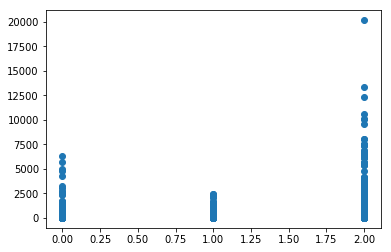

In [216]:
plt.scatter(df_total['sentiment'],df_total['word_count_nostop'])

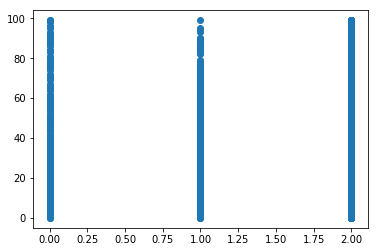

In [217]:
plt.scatter(df_total.loc[df_total['punctuation_counts']<100,:].sentiment,df_total.loc[df_total['punctuation_counts']<100,:].punctuation_counts)

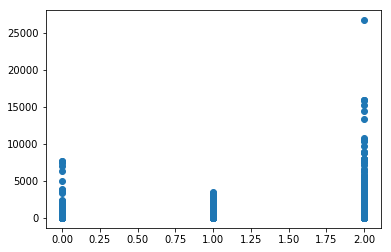

In [218]:
plt.scatter(df_total['sentiment'],df_total['word_count_withstop'])

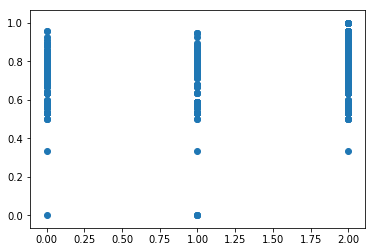

In [219]:
plt.scatter(df_total['sentiment'],df_total['Neutral'])

In [220]:
df_total.head()

,Negative,Neutral,Positive,column,drug,sentiment,text,unique_hash,text_feature,punctuation_counts,numbers_counts,text_feature_words,text_feature_words_nostop,word_count_withstop,word_count_nostop
0,0.354354,0.53003,0.115616,train,gilenya,2.0,autoimmune diseases tend to come in clusters. ...,2e180be4c9214c1f5ab51fd8cc32bc80c9f612e0,autoi ammune diseases tend to come in clusters...,22,0,"[autoi, ammune, diseases, tend, to, come, in, ...","[autoi, ammune, diseases, tend, come, clusters...",106,63
1,0.354354,0.53003,0.115616,train,gilenya,2.0,i can completely understand why you’d want to ...,9eba8f80e7e20f3a2f48685530748fbfa95943e4,i can completely understand why you punctuatio...,40,0,"[i, can, completely, understand, why, you, pun...","[completely, understand, punctuation, want, tr...",271,137
2,0.354354,0.53003,0.115616,train,gilenya,2.0,well as expected my neurologist wants me to st...,08c3c0c702fc97d290204b37798ac62005da5626,well as expected my neurologist wants me to st...,22,3,"[well, as, expected, my, neurologist, wants, m...","[well, expected, neurologist, wants, start, ty...",171,98
3,0.354354,0.53003,0.115616,train,gilenya,2.0,multiple sclerosis (ms) can be thought of as a...,497b861718dcea8618daa71fff8ccdeff2e5b161,multiple sclerosis punctuation ms punctuation...,344,19,"[multiple, sclerosis, punctuation, ms, punctua...","[multiple, sclerosis, punctuation, ms, punctua...",2321,1608
4,0.354354,0.53003,0.115616,train,gilenya,2.0,you mention 8 recent developments and 25 issue...,029b7632b8a7c09b908a57a14c98f74a944fc5ca,you mention numbers recent developments and ...,32,5,"[you, mention, numbers, recent, developments, ...","[mention, numbers, recent, developments, numbe...",216,136


## Trying prediction with just drug and probability columns

In [384]:
df_notext = df_total[['Negative','Neutral','Positive','column','drug']]

In [385]:
df_notext.head()

,Negative,Neutral,Positive,column,drug
0,0.354354,0.53003,0.115616,train,gilenya
1,0.354354,0.53003,0.115616,train,gilenya
2,0.354354,0.53003,0.115616,train,gilenya
3,0.354354,0.53003,0.115616,train,gilenya
4,0.354354,0.53003,0.115616,train,gilenya


In [386]:
df_onehot = pd.DataFrame(pd.get_dummies(df_notext.drug))

In [388]:
df_notext = pd.concat([df_notext,df_onehot],axis=1)

In [399]:
train_notext = df_notext.loc[df_notext['column'] == 'train']

In [401]:
test_notext = df_notext.loc[df_notext['column'] == 'test']

In [411]:
train_notext.head()

,Negative,Neutral,Positive,afainib,afatinib,aflibercept,alecensa,alectinib,alectnib,alemtuzumab,...,tofacitinib,trametinib,tysabri,upadacitinib,ustekinumab,vedolizumab,vitrectomy,xalkori,yervoy,zykadia
0,0.354354,0.53003,0.115616,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0.354354,0.53003,0.115616,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0.354354,0.53003,0.115616,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0.354354,0.53003,0.115616,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0.354354,0.53003,0.115616,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [409]:
train_no_text = train_processed[['drug','Negative',"Neutral",'Positive']]
train_notext.drop(columns = ['column','drug'],inplace=True)

/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/pandas/core/frame.py:3940: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


In [410]:
test_no_text = test_processed[['drug','Negative',"Neutral",'Positive']]
test_notext.drop(columns = ['column','drug'],inplace=True)

/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/pandas/core/frame.py:3940: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


In [452]:
train_notext_array

array([[0.35435435, 0.53003003, 0.11561562, ..., 0.        , 0.        ,
        0.        ],
       [0.35435435, 0.53003003, 0.11561562, ..., 0.        , 0.        ,
        0.        ],
       [0.35435435, 0.53003003, 0.11561562, ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 1.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [1.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.03448276, 0.89655172, 0.06896552, ..., 0.        , 0.        ,
        0.        ]])

## XG Boost Classifier

In [ ]:
from xgboost import XGBClassifier
classifier = XGBClassifier(silent=False, 
                      scale_pos_weight=1,
                      learning_rate=0.01,  
                      colsample_bytree = 0.4,
                      subsample = 0.8,
                      objective ='gbtree', 
                      n_estimators=1000, 
                      reg_alpha = 0.3,
                      max_depth=4, 
                      gamma=10)

In [453]:
modelfit(classifier, train_notext_array, list_train_labels_notext, test_notext_array,test_orig[['unique_hash']],"gbm_res_notext_tfidf" )

/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predic


Model Report
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       617
           1       0.00      0.00      0.00       837
           2       0.72      1.00      0.84      3825

   micro avg       0.72      0.72      0.72      5279
   macro avg       0.24      0.33      0.28      5279
weighted avg       0.53      0.72      0.61      5279

CV Score : Mean - 0.2800967 | Std - 0.0001506906 | Min - 0.2799122 | Max - 0.2802198


/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


## Proceeding with the text column:
As the Drug + Probability columns did not yield us good results we move on to prediction with the text column.... Further doing TFID to the text column after splitting the test and train columns from the dataframe

In [221]:
vectorizer = TfidfVectorizer()

In [222]:
train_processed = df_total.loc[df_total['column'] == 'train']

In [223]:
train_processed.shape

(5279, 15)

In [224]:
test_processed = df_total.loc[df_total['column'] == 'test']

In [225]:
test_processed.shape

(2924, 15)

In [226]:
train_processed = train_processed.drop(columns = ['column','text','unique_hash','text_feature_words','text_feature_words_nostop'])

In [227]:
test_processed = test_processed.drop(columns = ['column','text','unique_hash','text_feature_words','text_feature_words_nostop'])

In [228]:
test_processed = test_processed.drop(columns = ['sentiment'])

In [229]:
train_processed.head()

,Negative,Neutral,Positive,drug,sentiment,text_feature,punctuation_counts,numbers_counts,word_count_withstop,word_count_nostop
0,0.354354,0.53003,0.115616,gilenya,2.0,autoi ammune diseases tend to come in clusters...,22,0,106,63
1,0.354354,0.53003,0.115616,gilenya,2.0,i can completely understand why you punctuatio...,40,0,271,137
2,0.354354,0.53003,0.115616,gilenya,2.0,well as expected my neurologist wants me to st...,22,3,171,98
3,0.354354,0.53003,0.115616,gilenya,2.0,multiple sclerosis punctuation ms punctuation...,344,19,2321,1608
4,0.354354,0.53003,0.115616,gilenya,2.0,you mention numbers recent developments and ...,32,5,216,136


In [230]:
test_processed.head()

,Negative,Neutral,Positive,drug,text_feature,punctuation_counts,numbers_counts,word_count_withstop,word_count_nostop
0,0.218487,0.718487,0.063025,fingolimod,numbers numbers numbers punctuation previ...,4,5,19,16
1,0.218487,0.718487,0.063025,fingolimod,on fingoli amod and have been since december ...,4,4,37,22
2,0.148148,0.788889,0.062963,humira,apparently it punctuation s shingles punctuati...,55,28,261,181
3,0.105590,0.813665,0.080745,tagrisso,if the docetaxel doing once a week x numbers ...,41,81,273,233
4,0.086957,0.776398,0.136646,stelara,cc punctuation stelara worked in a matter of ...,176,122,843,583


In [231]:
train_processed['sentiment'].value_counts()

2.0    3825
1.0     837
0.0     617
Name: sentiment, dtype: int64

## Treating the Imbalance in the target class

In [232]:
# Class count
count_class_0, count_class_1, count_class_2 = train_processed.sentiment.value_counts()

# Divide by class
df_class_0 = train_processed[train_processed['sentiment'] == 0]
df_class_1 = train_processed[train_processed['sentiment'] == 1]
df_class_2 = train_processed[train_processed['sentiment'] == 2]

In [233]:
count_class_1

837

Random under-sampling:
1.0    837
2.0    837
0.0    617
Name: sentiment, dtype: int64


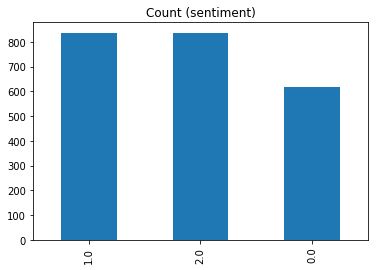

In [234]:
df_class_2_under = df_class_2.sample(count_class_1)
df_test_under = pd.concat([df_class_0, df_class_2_under, df_class_1], axis=0)

print('Random under-sampling:')
print(df_test_under.sentiment.value_counts())

df_test_under.sentiment.value_counts().plot(kind='bar', title='Count (sentiment)'); 

In [235]:
train_processed = df_test_under

# TFIDF

In [298]:
def tf(data):
    tfidf = TfidfVectorizer(ngram_range=(1, 2))
    emb = tfidf.fit_transform(data)
    return emb, tfidf

### Train Data

In [299]:
list_train_to_tfidf = train_processed["text_feature"].tolist()
list_train_labels = train_processed["sentiment"].tolist()

### Test Data

In [300]:
list_test_to_tfidf = test_processed["text_feature"].tolist()

In [301]:
test_processed[test_processed.isna().any(axis=1)]

,Negative,Neutral,Positive,drug,text_feature,punctuation_counts,numbers_counts,word_count_withstop,word_count_nostop


### Train and Test to TFIDF

In [302]:
X_train_tfidf, tfidf = tf(list_train_to_tfidf)
X_test_tfidf = tfidf.transform(list_test_to_tfidf)

In [303]:
X_train_tfidf.shape

(2291, 225830)

In [304]:
col_to_append = ["Negative","Neutral","Positive"]

In [305]:
train_col_to_add_np = np.array(train_processed[col_to_append])

In [306]:
test_col_to_add_np = np.array(test_processed[col_to_append])

In [307]:
X_train_tfidf_addition_col = sp.sparse.hstack((X_train_tfidf, train_col_to_add_np))

In [308]:
X_test_tfidf_addition_col = sp.sparse.hstack((X_test_tfidf, test_col_to_add_np))

In [309]:
X_train_tfidf_addition_col.shape

(2291, 225833)

## Logistic regression where the parameters are obtained using Grid search

In [ ]:
grid={"C":np.logspace(0,2,5), "penalty":["l2"],"tol":np.logspace(-3,3,5),
      "solver":["newton-cg"],'class_weight':['balanced'],'multi_class':["auto"],'max_iter':[1000]}# l1 lasso l2 ridge

In [ ]:
logreg=LogisticRegression()
logreg_cv=GridSearchCV(logreg,grid,cv=10,scoring= 'f1_macro')
logreg_cv.fit(X_train_tfidf_addition_col, list_train_labels)

print("tuned hpyerparameters :(best parameters) ",logreg_cv.best_params_)
print("accuracy :",logreg_cv.best_score_)

In [248]:
from sklearn.linear_model import LogisticRegression

log_cv = LogisticRegression(C=1.0,multi_class ='auto', penalty= 'l2',solver='newton-cg', tol= 10.0, class_weight='balanced',random_state=40)
log_cv.fit(X_train_tfidf_addition_col, list_train_labels)


LogisticRegression(C=1.0, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='auto', n_jobs=None, penalty='l2', random_state=40,
          solver='newton-cg', tol=10.0, verbose=0, warm_start=False)

In [249]:
test_orig['sentiment'] = log_cv.predict(X_test_tfidf_addition_col)

In [250]:
from sklearn.metrics import classification_report

In [251]:
print(classification_report(log_cv.predict(X_train_tfidf_addition_col),list_train_labels))

              precision    recall  f1-score   support

         0.0       0.81      0.78      0.79       636
         1.0       0.79      0.81      0.80       825
         2.0       0.78      0.79      0.79       830

   micro avg       0.79      0.79      0.79      2291
   macro avg       0.79      0.79      0.79      2291
weighted avg       0.79      0.79      0.79      2291



In [252]:
test_orig['sentiment'].value_counts()

2.0    1510
1.0     785
0.0     629
Name: sentiment, dtype: int64

In [253]:
submission = test_orig[['unique_hash','sentiment']]

In [254]:
submission['sentiment'].value_counts()

2.0    1510
1.0     785
0.0     629
Name: sentiment, dtype: int64

In [255]:
submission.to_csv("logi_tfidf_balanced.csv",index = False)

## XG Boost Classifer
A frame work that will predict and write the output automatically

In [273]:
def modelfit(alg, train_X, train_Y,test_X, submission ,filename, performCV=True,cv_folds=5):
    #Fit the algorithm on the data
    alg.fit(train_X, train_Y)
        
    #Predict training set:
    dtrain_predictions = alg.predict(train_X)
    
    #Perform cross-validation:
    if performCV:
        cv_score = cross_val_score(alg, train_X, train_Y, cv=cv_folds, scoring='f1_macro')

    #Print model report:
    print("\nModel Report")
    print(classification_report(train_Y, dtrain_predictions))
    
    if performCV:
        print("CV Score : Mean - %.7g | Std - %.7g | Min - %.7g | Max - %.7g" % (np.mean(cv_score),np.std(cv_score),np.min(cv_score),np.max(cv_score)))
    submission["sentiment"] = alg.predict(test_X)
    file = "output/"+filename+".csv"
    submission.to_csv(file,index = False)

In [261]:
!pip install xgboost

    100% |████████████████████████████████| 142.8MB 345kB/s eta 0:00:01
You are using pip version 10.0.1, however version 19.2.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [296]:
gbm0 = GradientBoostingClassifier(random_state=10) 
modelfit(gbm0, X_train_notext_tfidf_addition_col, list_train_labels, X_test_notext_tfidf_addition_col,test_orig[['unique_hash']],"gbm_res_notext_tfidf" )


Model Report
              precision    recall  f1-score   support

         0.0       0.41      0.45      0.43       617
         1.0       0.57      0.44      0.50       837
         2.0       0.49      0.56      0.53       837

   micro avg       0.49      0.49      0.49      2291
   macro avg       0.49      0.49      0.48      2291
weighted avg       0.50      0.49      0.49      2291

CV Score : Mean - 0.1614546 | Std - 0.05888361 | Min - 0.1192074 | Max - 0.2779784


ValueError: Number of features of the model must match the input. Model n_features is 86 and input n_features is 98 

In [293]:
X_train_notext_tfidf_addition_col.shape

(2291, 86)

In [294]:
len(list_train_labels)

2291

In [295]:
X_test_notext_tfidf_addition_col.shape

(2924, 98)

In [262]:
from xgboost import XGBClassifier

In [310]:
from xgboost import XGBClassifier
classifier = XGBClassifier(silent=False, 
                      scale_pos_weight=1,
                      learning_rate=0.01,  
                      colsample_bytree = 0.4,
                      subsample = 0.8,
                      objective ='gbtree', 
                      n_estimators=1000, 
                      reg_alpha = 0.3,
                      max_depth=4, 
                      gamma=10)

In [ ]:
classifier.fit(X_train_tfidf_addition_col, list_train_labels)


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bynode=1, colsample_bytree=0.4, gamma=10,
       learning_rate=0.01, max_delta_step=0, max_depth=4,
       min_child_weight=1, missing=None, n_estimators=1000, n_jobs=1,
       nthread=None, objective='multi:softprob', random_state=0,
       reg_alpha=0.3, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=False, subsample=0.8, verbosity=1)

In [ ]:
pred = classifier.predict(X_train_tfidf_addition_col)

In [ ]:
from sklearn.metrics import classification_report

In [ ]:
print(classification_report(pred, list_train_labels))

              precision    recall  f1-score   support

         0.0       0.43      0.68      0.53       391
         1.0       0.66      0.59      0.63       936
         2.0       0.65      0.57      0.61       964

   micro avg       0.60      0.60      0.60      2291
   macro avg       0.58      0.61      0.59      2291
weighted avg       0.62      0.60      0.60      2291



In [315]:
prediction = classifier.predict(X_test_tfidf_addition_col)

In [316]:
submission = test_orig[['unique_hash','sentiment']]

submission['sentiment'].value_counts()

submission.to_csv("XGB_tfidf_balanced_new.csv",index = False)

## Gradient boosting machine

In [270]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import cross_val_score

In [274]:
#Choose all predictors except target & IDcols
gbm0 = GradientBoostingClassifier(random_state=10) 
modelfit(gbm0, X_train_tfidf_addition_col, list_train_labels, X_test_tfidf_addition_col,test_orig[['unique_hash']],"gbm_res_tfidf" )


Model Report
              precision    recall  f1-score   support

         0.0       0.92      0.75      0.82       617
         1.0       0.84      0.88      0.86       837
         2.0       0.82      0.89      0.86       837

   micro avg       0.85      0.85      0.85      2291
   macro avg       0.86      0.84      0.85      2291
weighted avg       0.85      0.85      0.85      2291

CV Score : Mean - 0.3107967 | Std - 0.06441969 | Min - 0.2489676 | Max - 0.390333


/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [297]:
gbm = GradientBoostingClassifier()

gbm.fit(X_train_tfidf_addition_col, list_train_labels)


pred_gbm = gbm.predict(X_train_tfidf_addition_col)


print(classification_report(pred_gbm, list_train_labels))

              precision    recall  f1-score   support

         0.0       0.75      0.91      0.82       506
         1.0       0.87      0.84      0.85       871
         2.0       0.89      0.82      0.85       914

   micro avg       0.85      0.85      0.85      2291
   macro avg       0.84      0.86      0.84      2291
weighted avg       0.85      0.85      0.85      2291



In [ ]:
gbm.feature_importances_

In [ ]:
columns_tf = tfidf.get_feature_names()+["Negative","Neutral","Positive","punctuation_counts"]

In [ ]:
gbm0 = GradientBoostingClassifier(random_state=10) 
modelfit(gbm0, X_train_tfidf_addition_col, list_train_labels, X_test_tfidf_addition_col,test_orig[['unique_hash']],"gbm_res_tfidf" )

In [ ]:
feat_imp[:50]

In [ ]:
#pd.Series(gbm.feature_importances_,columns_tf).sort_values(ascending=False)


feat_imp = pd.Series(gbm.feature_importances_,columns_tf).sort_values(ascending=False)



feat_imp[:300].plot(kind='bar', title='Feature Importances')
plt.ylabel('Feature Importance Score')

In [469]:
test_orig['sentiment'] = gbm.predict(X_test_tfidf_addition_col)

In [470]:
submission_gbm = test_orig[['unique_hash','sentiment']]

In [471]:
submission_gbm.to_csv("/home/ec2-user/SageMaker/NLP/Laxmi/Sentiment_Classification/AV_output/result_GBM.csv",index = False)

In [ ]:
#Choose all predictors except target & IDcols
gbm0 = GradientBoostingClassifier(random_state=10)
modelfit(gbm0, X_train_tfidf_addition_col, list_train_labels)

## Stacking using XGB,GBM,LGBM and Random Forest Classification

In [777]:
from xgboost import XGBClassifier
from sklearn.ensemble import GradientBoostingClassifier
from lightgbm import LGBMClassifier
from  sklearn.ensemble import RandomForestClassifier

In [792]:
# Light Gradient Boosting Regressor
lightgbm = LGBMClassifier(
        n_estimators=50,
        num_leaves=15,
        colsample_bytree=.8,
        subsample=.8,
        max_depth=7,
        reg_alpha=.1,
        reg_lambda=.1,
        min_split_gain=.01
    )

In [793]:
xgboost = XGBClassifier(
 learning_rate =0.1,
 n_estimators=50,
 max_depth=5,
 min_child_weight=1,
 gamma=0,
 subsample=0.8,
 colsample_bytree=0.8,
 objective= 'multi:softmax',
 nthread=4,
 scale_pos_weight=1,
 seed=27)

In [794]:
gbr = GradientBoostingClassifier(criterion='friedman_mse', init=None,
 learning_rate=0.1, loss='deviance', max_depth=3,
 max_features=None, max_leaf_nodes=None,
 min_impurity_split=1e-07, min_samples_leaf=1,
 min_samples_split=2, min_weight_fraction_leaf=0.0,
 n_estimators=50, presort='auto', random_state=None,
 subsample=1.0, verbose=0, warm_start=False)

In [795]:
rf = RandomForestClassifier(
    n_estimators=500,
    criterion='gini',
    max_depth=100,
    min_samples_split=40,
    min_samples_leaf=10,
    min_weight_fraction_leaf=0.2,
    max_features='auto',
    max_leaf_nodes=None,
    min_impurity_decrease=0.0,
    min_impurity_split=None,
    bootstrap=True,
    oob_score=False,
    random_state=0,
    verbose=0,
    warm_start=False,
    class_weight='balanced'
)

In [796]:
from mlxtend.classifier import StackingCVClassifier

In [797]:
stack_gen_6 = StackingCVClassifier(classifiers=(xgboost, lightgbm, gbr, rf),
                                meta_classifier=gbr,
                                use_features_in_secondary=True)

In [784]:
def fit_models(algo,X_train,Y_train,X_test,submission,filename):
    print(str(algo))
    algo.fit(X_train, Y_train)
    
    prediction = algo.predict(X_train)
    print(classification_report(Y_train, prediction))
    
    submission["sentiment"] = algo.predict(X_test)
    file = "/home/ec2-user/SageMaker/NLP/Laxmi/Sentiment_Classification/AV_output/"+filename+".csv"
    submission.to_csv(file,index = False)

In [785]:
fit_models(lightgbm, X_train_tfidf_addition_col, list_train_labels, X_test_tfidf_addition_col,test_orig[['unique_hash']],"ligbm_res" )

LGBMClassifier(boosting_type='gbdt', colsample_bytree=0.8, learning_rate=0.1,
        max_bin=255, max_depth=7, min_child_samples=10, min_child_weight=5,
        min_split_gain=0.01, n_estimators=50, nthread=-1, num_leaves=15,
        objective='binary', reg_alpha=0.1, reg_lambda=0.1, seed=0,
        silent=True, subsample=0.8, subsample_for_bin=50000,
        subsample_freq=1)


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/lightgbm/basic.py:426: UserWarning: Converting data to scipy sparse matrix.
  warnings.warn('Converting data to scipy sparse matrix.')
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/lightgbm/basic.py:426: UserWarning: Converting data to scipy sparse matrix.
  warnings.warn('Converting data to scipy sparse matrix.')


              precision    recall  f1-score   support

         0.0       0.92      0.79      0.85       617
         1.0       0.85      0.89      0.87       837
         2.0       0.84      0.90      0.87       837

   micro avg       0.86      0.86      0.86      2291
   macro avg       0.87      0.86      0.86      2291
weighted avg       0.87      0.86      0.86      2291



/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/ipykernel/__main__.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [786]:
fit_models(xgboost, X_train_tfidf_addition_col, list_train_labels, X_test_tfidf_addition_col,test_orig[['unique_hash']],"xgboost_res" )

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bynode=1, colsample_bytree=0.8, gamma=0,
       learning_rate=0.1, max_delta_step=0, max_depth=5,
       min_child_weight=1, missing=None, n_estimators=50, n_jobs=1,
       nthread=4, objective='multi:softmax', random_state=0, reg_alpha=0,
       reg_lambda=1, scale_pos_weight=1, seed=27, silent=None,
       subsample=0.8, verbosity=1)
              precision    recall  f1-score   support

         0.0       0.94      0.83      0.88       617
         1.0       0.90      0.90      0.90       837
         2.0       0.87      0.93      0.90       837

   micro avg       0.90      0.90      0.90      2291
   macro avg       0.90      0.89      0.89      2291
weighted avg       0.90      0.90      0.90      2291



/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/ipykernel/__main__.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [787]:
fit_models(gbr, X_train_tfidf_addition_col, list_train_labels, X_test_tfidf_addition_col,test_orig[['unique_hash']],"gbr_res" )

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/tree/tree.py:283: DeprecationWarning: The min_impurity_split parameter is deprecated. Its default value will change from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  DeprecationWarning)
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/tree/tree.py:283: DeprecationWarning: The min_impurity_split parameter is deprecated. Its default value will change from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  DeprecationWarning)


GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=3,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=1e-07,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=50,
              n_iter_no_change=None, presort='auto', random_state=None,
              subsample=1.0, tol=0.0001, validation_fraction=0.1,
              verbose=0, warm_start=False)


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/tree/tree.py:283: DeprecationWarning: The min_impurity_split parameter is deprecated. Its default value will change from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  DeprecationWarning)
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/tree/tree.py:283: DeprecationWarning: The min_impurity_split parameter is deprecated. Its default value will change from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  DeprecationWarning)
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/tree/tree.py:283: DeprecationWarning: The min_impurity_split parameter is deprecated. Its default value will change from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  DeprecationWarning)
/home/ec2-user/anaconda3/

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/tree/tree.py:283: DeprecationWarning: The min_impurity_split parameter is deprecated. Its default value will change from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  DeprecationWarning)
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/tree/tree.py:283: DeprecationWarning: The min_impurity_split parameter is deprecated. Its default value will change from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  DeprecationWarning)
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/tree/tree.py:283: DeprecationWarning: The min_impurity_split parameter is deprecated. Its default value will change from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  DeprecationWarning)
/home/ec2-user/anaconda3/

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/tree/tree.py:283: DeprecationWarning: The min_impurity_split parameter is deprecated. Its default value will change from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  DeprecationWarning)
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/tree/tree.py:283: DeprecationWarning: The min_impurity_split parameter is deprecated. Its default value will change from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  DeprecationWarning)
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/tree/tree.py:283: DeprecationWarning: The min_impurity_split parameter is deprecated. Its default value will change from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  DeprecationWarning)
/home/ec2-user/anaconda3/

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/tree/tree.py:283: DeprecationWarning: The min_impurity_split parameter is deprecated. Its default value will change from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  DeprecationWarning)
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/tree/tree.py:283: DeprecationWarning: The min_impurity_split parameter is deprecated. Its default value will change from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  DeprecationWarning)
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/tree/tree.py:283: DeprecationWarning: The min_impurity_split parameter is deprecated. Its default value will change from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  DeprecationWarning)
/home/ec2-user/anaconda3/

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/tree/tree.py:283: DeprecationWarning: The min_impurity_split parameter is deprecated. Its default value will change from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  DeprecationWarning)
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/tree/tree.py:283: DeprecationWarning: The min_impurity_split parameter is deprecated. Its default value will change from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  DeprecationWarning)
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/tree/tree.py:283: DeprecationWarning: The min_impurity_split parameter is deprecated. Its default value will change from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  DeprecationWarning)
/home/ec2-user/anaconda3/

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/tree/tree.py:283: DeprecationWarning: The min_impurity_split parameter is deprecated. Its default value will change from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  DeprecationWarning)
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/tree/tree.py:283: DeprecationWarning: The min_impurity_split parameter is deprecated. Its default value will change from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  DeprecationWarning)
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/tree/tree.py:283: DeprecationWarning: The min_impurity_split parameter is deprecated. Its default value will change from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  DeprecationWarning)
/home/ec2-user/anaconda3/

              precision    recall  f1-score   support

         0.0       0.85      0.61      0.71       617
         1.0       0.76      0.81      0.78       837
         2.0       0.72      0.82      0.77       837

   micro avg       0.76      0.76      0.76      2291
   macro avg       0.78      0.75      0.75      2291
weighted avg       0.77      0.76      0.76      2291



/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/ipykernel/__main__.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [788]:
fit_models(rf, X_train_tfidf_addition_col, list_train_labels, X_test_tfidf_addition_col,test_orig[['unique_hash']],"rf_res" )

RandomForestClassifier(bootstrap=True, class_weight='balanced',
            criterion='gini', max_depth=100, max_features='auto',
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=10,
            min_samples_split=40, min_weight_fraction_leaf=0.2,
            n_estimators=500, n_jobs=-1, oob_score=False, random_state=0,
            verbose=0, warm_start=False)
              precision    recall  f1-score   support

         0.0       0.51      0.45      0.48       617
         1.0       0.52      0.62      0.57       837
         2.0       0.54      0.48      0.51       837

   micro avg       0.52      0.52      0.52      2291
   macro avg       0.52      0.52      0.52      2291
weighted avg       0.52      0.52      0.52      2291



/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/ipykernel/__main__.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [798]:
fit_models(stack_gen_6, X_train_tfidf_addition_col, list_train_labels, X_test_tfidf_addition_col,test_orig[['unique_hash']],"stack_gen_6_res" )

StackingCVClassifier(classifiers=(XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bynode=1, colsample_bytree=0.8, gamma=0,
       learning_rate=0.1, max_delta_step=0, max_depth=5,
       min_child_weight=1, missing=None, n_estimators=50, n_jobs=1,
       nthread=4, objective='multi:...imators=500, n_jobs=None, oob_score=False, random_state=0,
            verbose=0, warm_start=False)),
           cv=2, drop_last_proba=False,
           meta_classifier=GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=3,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=1e-07,
              min_samples_leaf=1, mi...      subsample=1.0, tol=0.0001, validation_fraction=0.1,
              verbose=0, warm_start=False),
           n_jobs=None, pre_dispatch='2*n_jobs', random_state=None,
           shuffle=True, store_train_meta_features

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/tree/tree.py:283: DeprecationWarning: The min_impurity_split parameter is deprecated. Its default value will change from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  DeprecationWarning)
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/tree/tree.py:283: DeprecationWarning: The min_impurity_split parameter is deprecated. Its default value will change from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  DeprecationWarning)
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/tree/tree.py:283: DeprecationWarning: The min_impurity_split parameter is deprecated. Its default value will change from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  DeprecationWarning)
/home/ec2-user/anaconda3/

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/tree/tree.py:283: DeprecationWarning: The min_impurity_split parameter is deprecated. Its default value will change from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  DeprecationWarning)
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/tree/tree.py:283: DeprecationWarning: The min_impurity_split parameter is deprecated. Its default value will change from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  DeprecationWarning)
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/tree/tree.py:283: DeprecationWarning: The min_impurity_split parameter is deprecated. Its default value will change from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  DeprecationWarning)
/home/ec2-user/anaconda3/

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/tree/tree.py:283: DeprecationWarning: The min_impurity_split parameter is deprecated. Its default value will change from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  DeprecationWarning)
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/tree/tree.py:283: DeprecationWarning: The min_impurity_split parameter is deprecated. Its default value will change from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  DeprecationWarning)
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/tree/tree.py:283: DeprecationWarning: The min_impurity_split parameter is deprecated. Its default value will change from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  DeprecationWarning)
/home/ec2-user/anaconda3/

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/tree/tree.py:283: DeprecationWarning: The min_impurity_split parameter is deprecated. Its default value will change from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  DeprecationWarning)
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/tree/tree.py:283: DeprecationWarning: The min_impurity_split parameter is deprecated. Its default value will change from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  DeprecationWarning)
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/tree/tree.py:283: DeprecationWarning: The min_impurity_split parameter is deprecated. Its default value will change from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  DeprecationWarning)
/home/ec2-user/anaconda3/

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/tree/tree.py:283: DeprecationWarning: The min_impurity_split parameter is deprecated. Its default value will change from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  DeprecationWarning)
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/tree/tree.py:283: DeprecationWarning: The min_impurity_split parameter is deprecated. Its default value will change from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  DeprecationWarning)
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/tree/tree.py:283: DeprecationWarning: The min_impurity_split parameter is deprecated. Its default value will change from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  DeprecationWarning)
/home/ec2-user/anaconda3/

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/tree/tree.py:283: DeprecationWarning: The min_impurity_split parameter is deprecated. Its default value will change from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  DeprecationWarning)
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/tree/tree.py:283: DeprecationWarning: The min_impurity_split parameter is deprecated. Its default value will change from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  DeprecationWarning)
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/tree/tree.py:283: DeprecationWarning: The min_impurity_split parameter is deprecated. Its default value will change from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  DeprecationWarning)
/home/ec2-user/anaconda3/

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/tree/tree.py:283: DeprecationWarning: The min_impurity_split parameter is deprecated. Its default value will change from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  DeprecationWarning)
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/tree/tree.py:283: DeprecationWarning: The min_impurity_split parameter is deprecated. Its default value will change from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  DeprecationWarning)
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/tree/tree.py:283: DeprecationWarning: The min_impurity_split parameter is deprecated. Its default value will change from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  DeprecationWarning)
/home/ec2-user/anaconda3/

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/tree/tree.py:283: DeprecationWarning: The min_impurity_split parameter is deprecated. Its default value will change from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  DeprecationWarning)
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/tree/tree.py:283: DeprecationWarning: The min_impurity_split parameter is deprecated. Its default value will change from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  DeprecationWarning)
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/tree/tree.py:283: DeprecationWarning: The min_impurity_split parameter is deprecated. Its default value will change from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  DeprecationWarning)
/home/ec2-user/anaconda3/

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/tree/tree.py:283: DeprecationWarning: The min_impurity_split parameter is deprecated. Its default value will change from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  DeprecationWarning)
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/tree/tree.py:283: DeprecationWarning: The min_impurity_split parameter is deprecated. Its default value will change from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  DeprecationWarning)
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/tree/tree.py:283: DeprecationWarning: The min_impurity_split parameter is deprecated. Its default value will change from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  DeprecationWarning)
/home/ec2-user/anaconda3/

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/tree/tree.py:283: DeprecationWarning: The min_impurity_split parameter is deprecated. Its default value will change from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  DeprecationWarning)
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/tree/tree.py:283: DeprecationWarning: The min_impurity_split parameter is deprecated. Its default value will change from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  DeprecationWarning)
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/tree/tree.py:283: DeprecationWarning: The min_impurity_split parameter is deprecated. Its default value will change from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  DeprecationWarning)
/home/ec2-user/anaconda3/

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/tree/tree.py:283: DeprecationWarning: The min_impurity_split parameter is deprecated. Its default value will change from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  DeprecationWarning)
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/tree/tree.py:283: DeprecationWarning: The min_impurity_split parameter is deprecated. Its default value will change from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  DeprecationWarning)
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/tree/tree.py:283: DeprecationWarning: The min_impurity_split parameter is deprecated. Its default value will change from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  DeprecationWarning)
/home/ec2-user/anaconda3/

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/tree/tree.py:283: DeprecationWarning: The min_impurity_split parameter is deprecated. Its default value will change from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  DeprecationWarning)
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/tree/tree.py:283: DeprecationWarning: The min_impurity_split parameter is deprecated. Its default value will change from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  DeprecationWarning)
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/tree/tree.py:283: DeprecationWarning: The min_impurity_split parameter is deprecated. Its default value will change from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  DeprecationWarning)
/home/ec2-user/anaconda3/

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/tree/tree.py:283: DeprecationWarning: The min_impurity_split parameter is deprecated. Its default value will change from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  DeprecationWarning)
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/tree/tree.py:283: DeprecationWarning: The min_impurity_split parameter is deprecated. Its default value will change from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  DeprecationWarning)
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/tree/tree.py:283: DeprecationWarning: The min_impurity_split parameter is deprecated. Its default value will change from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  DeprecationWarning)
/home/ec2-user/anaconda3/

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/tree/tree.py:283: DeprecationWarning: The min_impurity_split parameter is deprecated. Its default value will change from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  DeprecationWarning)
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/tree/tree.py:283: DeprecationWarning: The min_impurity_split parameter is deprecated. Its default value will change from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  DeprecationWarning)
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/tree/tree.py:283: DeprecationWarning: The min_impurity_split parameter is deprecated. Its default value will change from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  DeprecationWarning)
/home/ec2-user/anaconda3/

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/tree/tree.py:283: DeprecationWarning: The min_impurity_split parameter is deprecated. Its default value will change from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  DeprecationWarning)
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/tree/tree.py:283: DeprecationWarning: The min_impurity_split parameter is deprecated. Its default value will change from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  DeprecationWarning)
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/tree/tree.py:283: DeprecationWarning: The min_impurity_split parameter is deprecated. Its default value will change from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  DeprecationWarning)
/home/ec2-user/anaconda3/

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/tree/tree.py:283: DeprecationWarning: The min_impurity_split parameter is deprecated. Its default value will change from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  DeprecationWarning)
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/tree/tree.py:283: DeprecationWarning: The min_impurity_split parameter is deprecated. Its default value will change from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  DeprecationWarning)
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/tree/tree.py:283: DeprecationWarning: The min_impurity_split parameter is deprecated. Its default value will change from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  DeprecationWarning)
/home/ec2-user/anaconda3/

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/tree/tree.py:283: DeprecationWarning: The min_impurity_split parameter is deprecated. Its default value will change from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  DeprecationWarning)
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/tree/tree.py:283: DeprecationWarning: The min_impurity_split parameter is deprecated. Its default value will change from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  DeprecationWarning)
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/tree/tree.py:283: DeprecationWarning: The min_impurity_split parameter is deprecated. Its default value will change from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  DeprecationWarning)
/home/ec2-user/anaconda3/

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/tree/tree.py:283: DeprecationWarning: The min_impurity_split parameter is deprecated. Its default value will change from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  DeprecationWarning)
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/tree/tree.py:283: DeprecationWarning: The min_impurity_split parameter is deprecated. Its default value will change from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  DeprecationWarning)
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/tree/tree.py:283: DeprecationWarning: The min_impurity_split parameter is deprecated. Its default value will change from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  DeprecationWarning)
/home/ec2-user/anaconda3/

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/tree/tree.py:283: DeprecationWarning: The min_impurity_split parameter is deprecated. Its default value will change from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  DeprecationWarning)
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/tree/tree.py:283: DeprecationWarning: The min_impurity_split parameter is deprecated. Its default value will change from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  DeprecationWarning)
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/tree/tree.py:283: DeprecationWarning: The min_impurity_split parameter is deprecated. Its default value will change from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  DeprecationWarning)
/home/ec2-user/anaconda3/

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/tree/tree.py:283: DeprecationWarning: The min_impurity_split parameter is deprecated. Its default value will change from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  DeprecationWarning)
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/tree/tree.py:283: DeprecationWarning: The min_impurity_split parameter is deprecated. Its default value will change from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  DeprecationWarning)
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/tree/tree.py:283: DeprecationWarning: The min_impurity_split parameter is deprecated. Its default value will change from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  DeprecationWarning)
/home/ec2-user/anaconda3/

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/tree/tree.py:283: DeprecationWarning: The min_impurity_split parameter is deprecated. Its default value will change from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  DeprecationWarning)
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/tree/tree.py:283: DeprecationWarning: The min_impurity_split parameter is deprecated. Its default value will change from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  DeprecationWarning)
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/tree/tree.py:283: DeprecationWarning: The min_impurity_split parameter is deprecated. Its default value will change from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  DeprecationWarning)
/home/ec2-user/anaconda3/

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/tree/tree.py:283: DeprecationWarning: The min_impurity_split parameter is deprecated. Its default value will change from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  DeprecationWarning)
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/tree/tree.py:283: DeprecationWarning: The min_impurity_split parameter is deprecated. Its default value will change from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  DeprecationWarning)
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/tree/tree.py:283: DeprecationWarning: The min_impurity_split parameter is deprecated. Its default value will change from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  DeprecationWarning)
/home/ec2-user/anaconda3/

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/tree/tree.py:283: DeprecationWarning: The min_impurity_split parameter is deprecated. Its default value will change from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  DeprecationWarning)
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/tree/tree.py:283: DeprecationWarning: The min_impurity_split parameter is deprecated. Its default value will change from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  DeprecationWarning)
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/tree/tree.py:283: DeprecationWarning: The min_impurity_split parameter is deprecated. Its default value will change from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  DeprecationWarning)
/home/ec2-user/anaconda3/

              precision    recall  f1-score   support

         0.0       0.93      0.81      0.87       617
         1.0       0.85      0.87      0.86       837
         2.0       0.84      0.90      0.87       837

   micro avg       0.86      0.86      0.86      2291
   macro avg       0.87      0.86      0.86      2291
weighted avg       0.87      0.86      0.86      2291



/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/lightgbm/basic.py:426: UserWarning: Converting data to scipy sparse matrix.
  warnings.warn('Converting data to scipy sparse matrix.')
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/ipykernel/__main__.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [ ]:
# Light Gradient Boosting Regressor
lightgbm = LGBMRegressor(objective='regression', 
                       num_leaves=6,
                       learning_rate=0.01, 
                       n_estimators=7000,
                       max_bin=200, 
                       bagging_fraction=0.8,
                       bagging_freq=4, 
                       bagging_seed=8,
                       feature_fraction=0.2,
                       feature_fraction_seed=8,
                       min_sum_hessian_in_leaf = 11,
                       verbose=-1,
                       random_state=42)

# XGBoost Regressor
xgboost = XGBRegressor(learning_rate=0.01,
                       n_estimators=6000,
                       max_depth=4,
                       min_child_weight=0,
                       gamma=0.6,
                       subsample=0.7,
                       colsample_bytree=0.7,
                       objective='reg:squarederror',
                       nthread=-1,
                       scale_pos_weight=1,
                       seed=27,
                       reg_alpha=0.00006,
                       random_state=42)


# Gradient Boosting Regressor
gbr = GradientBoostingRegressor(n_estimators=6000,
                                learning_rate=0.01,
                                max_depth=4,
                                max_features='sqrt',
                                min_samples_leaf=15,
                                min_samples_split=10,
                                loss='huber',
                                random_state=42)  

# Ridge Regressor
ridge_alphas = [1e-15, 1e-10, 1e-8, 9e-4, 7e-4, 5e-4, 3e-4, 1e-4, 1e-3, 5e-2, 1e-2, 0.1, 0.3, 1, 3, 5, 10, 15, 18, 20, 30, 50, 75, 100]
ridge = make_pipeline(RobustScaler(), RidgeCV(alphas=ridge_alphas, cv=kf))

# Support Vector Regressor
svr = make_pipeline(RobustScaler(), SVR(C= 20, epsilon= 0.008, gamma=0.0003))

# Random Forest Regressor
rf = RandomForestRegressor(n_estimators=1200,
                          max_depth=15,
                          min_samples_split=5,
                          min_samples_leaf=5,
                          max_features=None,
                          oob_score=True,
                          random_state=42)

# Stack up all the models above, optimized using gbr
stack_gen_6 = StackingCVRegressor(regressors=(xgboost, lightgbm, svr, ridge, gbr, rf),
                                meta_regressor=gbr,
                                use_features_in_secondary=True)

## Keras Functional Model Using FASTEXT from Facebook

In [85]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

from sklearn.feature_extraction.text import CountVectorizer
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense, Embedding, LSTM, SpatialDropout1D
from sklearn.model_selection import train_test_split
from keras.utils.np_utils import to_categorical
import re

from keras.layers import LSTM, Dense, Bidirectional, Input,Dropout,BatchNormalization, CuDNNGRU, CuDNNLSTM

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

In [86]:
max_fatures = 200
tokenizer = Tokenizer(num_words=max_fatures, split=' ')
tokenizer.fit_on_texts(train_processed['text_feature'].values)
X = tokenizer.texts_to_sequences(train_processed['text_feature'].values)
X = pad_sequences(X)

In [87]:
from keras import backend as K
def recall_m(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
        recall = true_positives / (possible_positives + K.epsilon())
        return recall

def precision_m(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

In [90]:
embed_dim = 128
lstm_out = 1

model = Sequential()
model.add(Embedding(max_fatures, embed_dim,input_length = X.shape[1]))
model.add(SpatialDropout1D(0.4))
model.add(CuDNNGRU(lstm_out))
model.add(Dense(3,activation='softmax'))
model.compile(loss = 'binary_crossentropy', optimizer='adam',metrics=['acc',f1_m,precision_m, recall_m])
print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, 9095, 128)         25600     
_________________________________________________________________
spatial_dropout1d_4 (Spatial (None, 9095, 128)         0         
_________________________________________________________________
cu_dnngru_1 (CuDNNGRU)       (None, 1)                 393       
_________________________________________________________________
dense_2 (Dense)              (None, 3)                 6         
Total params: 25,999
Trainable params: 25,999
Non-trainable params: 0
_________________________________________________________________
None


In [91]:
Y = pd.get_dummies(train_processed['sentiment']).values
X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size = 0.10, random_state = 42)
print(X_train.shape,Y_train.shape)
print(X_test.shape,Y_test.shape)

(2061, 9095) (2061, 3)
(230, 9095) (230, 3)


In [ ]:
batch_size = 1
model.fit(X_train, Y_train, epochs = 1, batch_size=batch_size, verbose = 2)

Epoch 1/1


In [335]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

In [336]:
def make_data(X):
    t = Tokenizer(num_words=len_voc)
    t.fit_on_texts(X)
    X = t.texts_to_sequences(X)
    X = pad_sequences(X, maxlen=max_len)
    return X, t.word_index

In [337]:
X, word_index = make_data(train_processed['text_feature'])

In [329]:
def load_embed(file):
    def get_coefs(word,*arr): 
        return word, np.asarray(arr, dtype='float32')
    
    if file == 'embeddings/cc.en.300.vec':
        embeddings_index = dict(get_coefs(*o.split(" ")) for o in open(file) if len(o)>100)
    else:
        embeddings_index = dict(get_coefs(*o.split(" ")) for o in open(file, encoding='latin'))
        
    return embeddings_index

In [330]:
wiki_news = 'embeddings/cc.en.300.vec'
print("Extracting FastText embedding")
embed_fasttext = load_embed(wiki_news)

Extracting FastText embedding


In [331]:
def make_embed_matrix(embeddings_index, word_index, len_voc):
    all_embs = np.stack(embeddings_index.values())
    emb_mean,emb_std = all_embs.mean(), all_embs.std()
    embed_size = all_embs.shape[1]
    word_index = word_index
    embedding_matrix = np.random.normal(emb_mean, emb_std, (len_voc, embed_size))
    
    for word, i in word_index.items():
        if i >= len_voc:
            continue
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None: 
            embedding_matrix[i] = embedding_vector
    
    return embedding_matrix

In [338]:
embedding = make_embed_matrix(embed_fasttext, word_index, len_voc)

In [323]:
len_voc = 95000
max_len = 60

In [325]:
from keras import backend as K

In [326]:
def f1(y_true, y_pred):
    def recall(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
        recall = true_positives / (possible_positives + K.epsilon())
        return recall

    def precision(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        return precision
    
    precision = precision(y_true, y_pred)
    recall = recall(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

In [494]:
import pandas as pd
import numpy as np
import operator 
import re
import gc
import keras
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_style('whitegrid')

In [495]:
from keras.models import Model
from keras.layers import Dense, Embedding, Bidirectional, CuDNNGRU, GlobalAveragePooling1D, GlobalMaxPooling1D, concatenate, Input, Dropout
from keras.optimizers import Adam

In [498]:
def make_model(embedding_matrix, embed_size=300, loss='binary_crossentropy'):
    inp    = Input(shape=(max_len,))
    x      = Embedding(len_voc, embed_size, weights=[embedding_matrix], trainable=False)(inp)
    x      = Bidirectional(CuDNNGRU(128, return_sequences=True))(x)
    x      = Bidirectional(CuDNNGRU(64, return_sequences=True))(x)
    x      = Bidirectional(CuDNNGRU(64, return_sequences=True))(x)
    x      = Bidirectional(CuDNNGRU(64, return_sequences=True))(x)
    x   = Dropout(0.6)(x)
    avg_pl = GlobalAveragePooling1D()(x)
    max_pl = GlobalMaxPooling1D()(x)
    concat = concatenate([avg_pl, max_pl])
    dense  = Dense(64, activation="relu")(concat)
    drop   = Dropout(0.6)(concat)
    dense  = Dense(64, activation="relu")(concat)
    output = Dense(3, activation="softmax")(concat)
    
    model  = Model(inputs=inp, outputs=output)
    model.compile(loss=loss, optimizer=Adam(lr=0.0001), metrics=['accuracy',f1])
    return model

In [499]:
model = make_model(embedding)

In [500]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_10 (InputLayer)           (None, 60)           0                                            
__________________________________________________________________________________________________
embedding_10 (Embedding)        (None, 60, 300)      28500000    input_10[0][0]                   
__________________________________________________________________________________________________
bidirectional_17 (Bidirectional (None, 60, 256)      330240      embedding_10[0][0]               
__________________________________________________________________________________________________
bidirectional_18 (Bidirectional (None, 60, 128)      123648      bidirectional_17[0][0]           
__________________________________________________________________________________________________
dropout_9 

In [501]:
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau

In [502]:
checkpoints = ModelCheckpoint('weights.hdf5', monitor="val_f1", mode="macro", verbose=True, save_best_only=True)
reduce_lr = ReduceLROnPlateau(monitor='val_f1', factor=0.1, patience=2, verbose=1, min_lr=0.000001)

/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/keras/callbacks.py:407: RuntimeWarning: ModelCheckpoint mode macro is unknown, fallback to auto mode.
  RuntimeWarning)


In [503]:
es = keras.callbacks.EarlyStopping(monitor='val_f1',
                              min_delta=0,
                              patience=3,
                              verbose=0, mode='macro')

/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/keras/callbacks.py:511: RuntimeWarning: EarlyStopping mode macro is unknown, fallback to auto mode.
  RuntimeWarning)


In [515]:
epochs = 200
batch_size = 512

In [516]:
from sklearn.preprocessing import LabelBinarizer, LabelEncoder



In [517]:
encoder = LabelEncoder()
encoder.fit(list_train_labels)
y_train = encoder.transform(list_train_labels)
num_classes = np.max(y_train) + 1
y_train = utils.to_categorical(y_train, num_classes)


In [518]:
history = model.fit(X, y_train, batch_size=batch_size, epochs=epochs, 
                    callbacks=[checkpoints, reduce_lr,es])

Epoch 1/200
2291/2291 [==============================] - 0s 69us/step - loss: 0.5993 - acc: 0.6849 - f1: 0.1954
Epoch 2/200
2291/2291 [==============================] - 0s 65us/step - loss: 0.5984 - acc: 0.6818 - f1: 0.1780
Epoch 3/200
 512/2291 [=====>........................] - ETA: 0s - loss: 0.5932 - acc: 0.6836 - f1: 0.1954

/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/keras/callbacks.py:434: RuntimeWarning: Can save best model only with val_f1 available, skipping.
  'skipping.' % (self.monitor), RuntimeWarning)
/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/keras/callbacks.py:1109: RuntimeWarning: Reduce LR on plateau conditioned on metric `val_f1` which is not available. Available metrics are: loss,acc,f1,lr
  (self.monitor, ','.join(list(logs.keys()))), RuntimeWarning
/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/keras/callbacks.py:569: RuntimeWarning: Early stopping conditioned on metric `val_f1` which is not available. Available metrics are: loss,acc,f1,lr
  (self.monitor, ','.join(list(logs.keys()))), RuntimeWarning


2291/2291 [==============================] - 0s 63us/step - loss: 0.5975 - acc: 0.6843 - f1: 0.1792
Epoch 4/200
2291/2291 [==============================] - 0s 63us/step - loss: 0.5967 - acc: 0.6846 - f1: 0.2079
Epoch 5/200
2291/2291 [==============================] - 0s 64us/step - loss: 0.5958 - acc: 0.6857 - f1: 0.2173
Epoch 6/200
2291/2291 [==============================] - 0s 63us/step - loss: 0.5940 - acc: 0.6853 - f1: 0.1974
Epoch 7/200
2291/2291 [==============================] - 0s 63us/step - loss: 0.5941 - acc: 0.6863 - f1: 0.2019
Epoch 8/200
2291/2291 [==============================] - 0s 64us/step - loss: 0.5927 - acc: 0.6870 - f1: 0.2128
Epoch 9/200
2291/2291 [==============================] - 0s 63us/step - loss: 0.5919 - acc: 0.6878 - f1: 0.2297
Epoch 10/200
2291/2291 [==============================] - 0s 63us/step - loss: 0.5913 - acc: 0.6892 - f1: 0.2382
Epoch 11/200
2291/2291 [==============================] - 0s 63us/step - loss: 0.5898 - acc: 0.6898 - f1: 0.2460
Ep

2291/2291 [==============================] - 0s 63us/step - loss: 0.4088 - acc: 0.8241 - f1: 0.7060
Epoch 148/200
2291/2291 [==============================] - 0s 63us/step - loss: 0.4041 - acc: 0.8264 - f1: 0.7109
Epoch 149/200
2291/2291 [==============================] - 0s 61us/step - loss: 0.4038 - acc: 0.8271 - f1: 0.7133
Epoch 150/200
2291/2291 [==============================] - 0s 63us/step - loss: 0.4015 - acc: 0.8253 - f1: 0.7086
Epoch 151/200
2291/2291 [==============================] - 0s 63us/step - loss: 0.4046 - acc: 0.8258 - f1: 0.7121
Epoch 152/200
2291/2291 [==============================] - 0s 64us/step - loss: 0.4019 - acc: 0.8292 - f1: 0.7157
Epoch 153/200
2291/2291 [==============================] - 0s 64us/step - loss: 0.3993 - acc: 0.8296 - f1: 0.7177
Epoch 154/200
2291/2291 [==============================] - 0s 64us/step - loss: 0.3963 - acc: 0.8301 - f1: 0.7182
Epoch 155/200
2291/2291 [==============================] - 0s 63us/step - loss: 0.3937 - acc: 0.8305 -

In [519]:
X_test, word_index = make_data(test_processed['text_feature'])

In [520]:
pred_val = model.predict(X_test, batch_size=512, verbose=1)

2924/2924 [==============================] - 0s 24us/step


In [521]:
test_orig['sentiment'] = pred_val.argmax(axis=-1)

In [522]:
test_orig['sentiment'].value_counts()

1    1199
2    1095
0     630
Name: sentiment, dtype: int64

In [523]:
test_orig[["unique_hash","sentiment"]].to_csv("keras.csv",index=False)

In [1]:
from imblearn.keras import BalancedBatchGenerator
from imblearn.under_sampling import NearMiss

Using TensorFlow backend.
